In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Pre-processing

In [256]:
df_bitcoin = pd.read_csv("../data/bitcoin.csv", na_values=["null", ""], keep_default_na=True, index_col=0, parse_dates=["date"])
df_rates = pd.read_csv("../data/FEDFUNDS.csv", parse_dates=["observation_date"])
df_gold = pd.read_csv("../data/gold_5min.csv", sep=";", parse_dates=["Date"])

In [257]:
df_bitcoin.columns.values

array(['date', 'active_addresses', 'tweets', 'top_100_percent',
       'difficulty', 'transactions', 'av_transaction_size', 'market_cap',
       'confirmation_time', 'median_transaction_value', 'send_usd',
       'google_trends', 'block_size', 'mining_profitability', 'hashrate',
       'sent_addresses', 'median_transaction_size', 'fee_reward',
       'av_transaction_value', 'full_name', 'coin'], dtype=object)

In [258]:
df_rates.columns.values

array(['observation_date', 'FEDFUNDS'], dtype=object)

In [259]:
df_gold.columns.values

array(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype=object)

In [260]:
df_gold.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

In [261]:
df_bitcoin.dtypes

date                        datetime64[ns]
active_addresses                   float64
tweets                             float64
top_100_percent                    float64
difficulty                         float64
transactions                       float64
av_transaction_size                float64
market_cap                         float64
confirmation_time                  float64
median_transaction_value           float64
send_usd                           float64
google_trends                      float64
block_size                         float64
mining_profitability               float64
hashrate                           float64
sent_addresses                     float64
median_transaction_size            float64
fee_reward                         float64
av_transaction_value               float64
full_name                           object
coin                                object
dtype: object

In [262]:
df_rates.dtypes

observation_date    datetime64[ns]
FEDFUNDS                   float64
dtype: object

In [263]:
df_bitcoin.shape

(4378, 21)

In [264]:
df_rates.shape

(121, 2)

In [265]:
df_bitcoin.isna().sum()

date                           0
active_addresses              27
tweets                      1978
top_100_percent               12
difficulty                     6
transactions                 261
av_transaction_size         4378
market_cap                   561
confirmation_time              8
median_transaction_value     561
send_usd                     561
google_trends                570
block_size                     6
mining_profitability         561
hashrate                       7
sent_addresses                 8
median_transaction_size     1205
fee_reward                   641
av_transaction_value         561
full_name                      0
coin                           0
dtype: int64

In [266]:
df_bitcoin.columns.values

array(['date', 'active_addresses', 'tweets', 'top_100_percent',
       'difficulty', 'transactions', 'av_transaction_size', 'market_cap',
       'confirmation_time', 'median_transaction_value', 'send_usd',
       'google_trends', 'block_size', 'mining_profitability', 'hashrate',
       'sent_addresses', 'median_transaction_size', 'fee_reward',
       'av_transaction_value', 'full_name', 'coin'], dtype=object)

In [267]:
df_bitcoin.count()

date                        4378
active_addresses            4351
tweets                      2400
top_100_percent             4366
difficulty                  4372
transactions                4117
av_transaction_size            0
market_cap                  3817
confirmation_time           4370
median_transaction_value    3817
send_usd                    3817
google_trends               3808
block_size                  4372
mining_profitability        3817
hashrate                    4371
sent_addresses              4370
median_transaction_size     3173
fee_reward                  3737
av_transaction_value        3817
full_name                   4378
coin                        4378
dtype: int64

In [268]:
df_bitcoin.shape

(4378, 21)

In [269]:
df_bitcoin = df_bitcoin.sort_values('date').reset_index(drop=True)
df_bitcoin['tweets'] = df_bitcoin['tweets'].fillna(0)
df_bitcoin['google_trends'] = df_bitcoin['google_trends'].fillna(0)
start = max(df_bitcoin['date'].min(), df_rates['observation_date'].min(), df_gold['Date'].min())
end   = min(df_bitcoin['date'].max(), df_rates['observation_date'].max(), df_gold['Date'].max())
daily_range = pd.date_range(start, end, freq='D')

df_rates = df_rates.sort_values('observation_date').reset_index(drop=True)
df_rates = df_rates.rename(columns={'observation_date': 'date'})

In [270]:
target_col = 'send_usd'
df_btc_daily = (
    df_bitcoin.set_index('date')
    .sort_index()
    .reindex(daily_range)
    .rename_axis('date')
)
numeric_cols = df_btc_daily.select_dtypes(include=[np.number]).columns.tolist()
feature_cols_to_ffill = [c for c in numeric_cols if c != target_col]
df_btc_daily[feature_cols_to_ffill] = df_btc_daily[feature_cols_to_ffill].ffill()

In [271]:
df_rates_daily = df_rates.set_index('date').sort_index()
df_rates_daily = df_rates_daily.reindex(daily_range).rename_axis('date')
df_rates_daily['FEDFUNDS'] = df_rates_daily['FEDFUNDS'].ffill()

In [272]:
df_gold = df_gold.dropna(subset=['Date']).sort_values('Date')

df_gold_daily = (
    df_gold
    .set_index('Date')
    .resample('D')
    .agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
)

df_gold_daily = df_gold_daily.reindex(daily_range).rename_axis('date')
price_cols = ['Open', 'High', 'Low', 'Close']
df_gold_daily[price_cols] = df_gold_daily[price_cols].ffill()
df_gold_daily['Volume'] = df_gold_daily['Volume'].fillna(0)

df_gold_daily = df_gold_daily.rename(columns={
    'Open': 'gold_open',
    'High': 'gold_high',
    'Low': 'gold_low',
    'Close': 'gold_close',
    'Volume': 'gold_volume'
})


In [273]:
df_merged = df_btc_daily.join([df_rates_daily['FEDFUNDS'], df_gold_daily])

In [274]:
df_merged[target_col] = pd.to_numeric(df_merged[target_col], errors='coerce')
df_merged = df_merged[(df_merged[target_col].notna()) & (df_merged[target_col] > 0)]

In [275]:
df_merged.shape

(1976, 26)

In [276]:
df_merged.columns.values

array(['active_addresses', 'tweets', 'top_100_percent', 'difficulty',
       'transactions', 'av_transaction_size', 'market_cap',
       'confirmation_time', 'median_transaction_value', 'send_usd',
       'google_trends', 'block_size', 'mining_profitability', 'hashrate',
       'sent_addresses', 'median_transaction_size', 'fee_reward',
       'av_transaction_value', 'full_name', 'coin', 'FEDFUNDS',
       'gold_open', 'gold_high', 'gold_low', 'gold_close', 'gold_volume'],
      dtype=object)

In [277]:
df_merged.isna().sum()

active_addresses               0
tweets                         0
top_100_percent                0
difficulty                     0
transactions                   0
av_transaction_size         1976
market_cap                     0
confirmation_time              0
median_transaction_value       0
send_usd                       0
google_trends                  0
block_size                     0
mining_profitability           0
hashrate                       0
sent_addresses                 0
median_transaction_size        0
fee_reward                     0
av_transaction_value           0
full_name                      0
coin                           0
FEDFUNDS                       0
gold_open                      2
gold_high                      2
gold_low                       2
gold_close                     2
gold_volume                    0
dtype: int64

Ranges por dataset:
        dataset               start                 end  days    rows
       gold_raw 2004-06-11 07:15:00 2025-07-15 19:45:00  7705 1413022
    bitcoin_raw 2009-01-03 00:00:00 2020-12-28 00:00:00  4378    4378
      rates_raw 2015-08-01 00:00:00 2025-08-01 00:00:00  3654     121
  btc_daily_idx 2015-08-01 00:00:00 2020-12-28 00:00:00  1977    1977
rates_daily_idx 2015-08-01 00:00:00 2020-12-28 00:00:00  1977    1977
 gold_daily_idx 2015-08-01 00:00:00 2020-12-28 00:00:00  1977    1977
     merged_idx 2015-08-01 00:00:00 2020-12-27 00:00:00  1976    1976

Cobertura FEDFUNDS (dados mensais originais):
  FEDFUNDS começa em: 2015-08-01  | termina em: 2025-08-01

No merge: 0 NaNs em FEDFUNDS de 1976 linhas
  NaNs antes do primeiro FEDFUNDS: 0
  NaNs após o último FEDFUNDS:    0


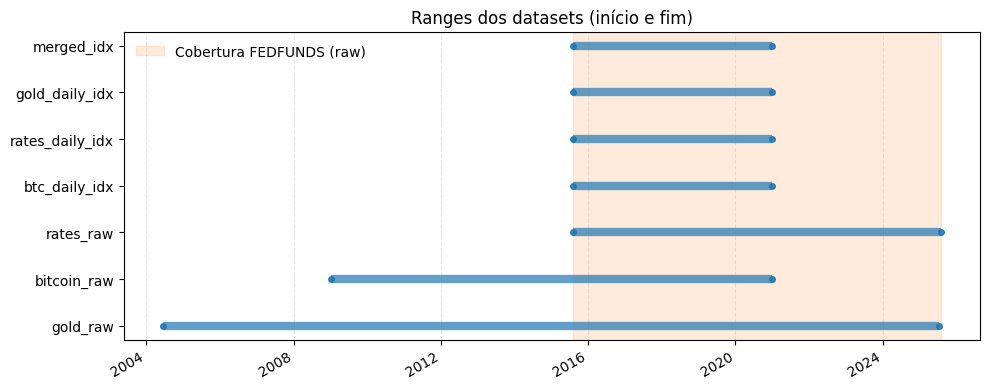

In [278]:
# python
def _col_or(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"Nenhuma das colunas {candidates} foi encontrada em {list(df.columns)}")

btc_date_col = _col_or(df_bitcoin, ['date'])
rates_date_col = _col_or(df_rates, ['date', 'observation_date'])
gold_date_col = _col_or(df_gold, ['Date', 'date'])

ranges = []

def add_range(name, idx, n_rows=None):
    start, end = pd.to_datetime(idx.min()), pd.to_datetime(idx.max())
    n_days = (end.normalize() - start.normalize()).days + 1
    ranges.append((name, start, end, n_days, n_rows if n_rows is not None else len(idx)))

add_range('bitcoin_raw', df_bitcoin[btc_date_col], len(df_bitcoin))
add_range('rates_raw', df_rates[rates_date_col], len(df_rates))
add_range('gold_raw', df_gold[gold_date_col], len(df_gold))

add_range('btc_daily_idx', df_btc_daily.index)
add_range('rates_daily_idx', df_rates_daily.index)
add_range('gold_daily_idx', df_gold_daily.index)
add_range('merged_idx', df_merged.index, len(df_merged))

ranges_df = pd.DataFrame(ranges, columns=['dataset', 'start', 'end', 'days', 'rows']).sort_values('start')
print("Ranges por dataset:")
print(ranges_df.to_string(index=False))

first_rate = pd.to_datetime(df_rates[rates_date_col].min())
last_rate  = pd.to_datetime(df_rates[rates_date_col].max())
print("\nCobertura FEDFUNDS (dados mensais originais):")
print(f"  FEDFUNDS começa em: {first_rate.date()}  | termina em: {last_rate.date()}")

n_total = len(df_merged)
n_nan = df_merged['FEDFUNDS'].isna().sum()
print(f"\nNo merge: {n_nan} NaNs em FEDFUNDS de {n_total} linhas")

mask_before = (df_merged.index < first_rate) & df_merged['FEDFUNDS'].isna()
mask_after  = (df_merged.index > last_rate) & df_merged['FEDFUNDS'].isna()
print(f"  NaNs antes do primeiro FEDFUNDS: {mask_before.sum()}")
print(f"  NaNs após o último FEDFUNDS:    {mask_after.sum()}")

fig, ax = plt.subplots(figsize=(10, 0.5 + 0.5*len(ranges_df)))
ypos = np.arange(len(ranges_df))
ax.set_yticks(ypos)
ax.set_yticklabels(ranges_df['dataset'])

for i, row in enumerate(ranges_df.itertuples(index=False)):
    ax.hlines(y=i, xmin=row.start, xmax=row.end, color='tab:blue', linewidth=6, alpha=0.7)
    ax.plot([row.start, row.end], [i, i], 'o', color='tab:blue', alpha=0.9, markersize=4)

ax.axvspan(first_rate, last_rate, color='tab:orange', alpha=0.15, label='Cobertura FEDFUNDS (raw)')
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.set_title('Ranges dos datasets (início e fim)')
ax.legend(loc='upper left', frameon=False)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [279]:
df_merged.to_csv("../data/dataset_merged.csv", index=True, encoding="utf-8", float_format='%.2f')

In [280]:
df_merged.describe(include="all")

,active_addresses,tweets,top_100_percent,difficulty,transactions,av_transaction_size,market_cap,confirmation_time,median_transaction_value,send_usd,...,fee_reward,av_transaction_value,full_name,coin,FEDFUNDS,gold_open,gold_high,gold_low,gold_close,gold_volume
count,1.976000e+03,1976.000000,1976.00000,1.976000e+03,1976.000000,0.0,1.976000e+03,1976.000000,1976.000000,1.976000e+03,...,1976.000000,1976.000000,1976,1976,1976.000000,1974.000000,1974.000000,1974.000000,1974.000000,1976.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,bitcoin,btc,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1976,1976,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.843168e+05,32678.095648,17.27676,5.810740e+12,263987.419534,NaN,9.907483e+10,9.747864,382.409709,9.073012e+09,...,5.105907,31832.918522,NaN,NaN,1.076447,1365.277102,1374.396221,1356.756515,1365.900517,69481.106781
std,1.674547e+05,19650.751882,2.06081,6.229650e+12,66087.140860,NaN,8.470372e+10,1.115982,508.210073,1.186011e+10,...,5.853568,37712.731629,NaN,NaN,0.814899,220.274281,222.890173,217.413201,220.379712,57573.239182
min,1.133370e+05,0.000000,13.19900,5.227830e+10,89360.000000,NaN,3.075433e+09,6.667000,0.091700,1.761133e+08,...,0.457000,1166.000000,NaN,NaN,0.050000,1050.920000,1063.460000,1046.230000,1051.550000,0.000000
25%,4.632572e+05,20592.000000,15.19175,2.867658e+11,215575.000000,NaN,1.226913e+10,9.000000,151.822000,1.906453e+09,...,1.186000,7661.750000,NaN,NaN,0.370000,1231.560000,1238.785000,1224.420000,1232.472500,0.000000
50%,5.747140e+05,27169.500000,18.04800,3.817753e+12,268454.000000,NaN,9.743264e+10,9.664000,269.900500,6.104110e+09,...,2.506000,22874.000000,NaN,NaN,1.040000,1289.465000,1295.765000,1282.675000,1290.470000,72045.000000
75%,6.851215e+05,37816.750000,19.03850,1.018349e+13,315114.250000,NaN,1.593126e+11,10.360000,454.156500,1.019563e+10,...,7.157750,37737.500000,NaN,NaN,1.820000,1464.317500,1472.480000,1456.562500,1463.057500,107636.000000


In [281]:
df_merged['send_usd'].isna().sum()

np.int64(0)

In [282]:
df_merged[["send_usd", "gold_close", "FEDFUNDS"]].corr()


,send_usd,gold_close,FEDFUNDS
send_usd,1.000000,0.471698,0.045103
gold_close,0.471698,1.000000,-0.231446
FEDFUNDS,0.045103,-0.231446,1.000000
